In [2]:
import pathlib
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, BatchNormalization
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [1]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images
License(s): ODbL-1.0
100% 34.0M/34.1M [00:02<00:00, 22.8MB/s]
100% 34.1M/34.1M [00:02<00:00, 13.5MB/s]


In [3]:
from zipfile import ZipFile

# Specify the path of the zip file
zip_path = '/content/alzheimers-dataset-4-class-of-images.zip'

# Unzip the dataset
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/alzahimer')

In [4]:
import os

# Check the contents of the unzipped dataset directory
extracted_folder = '/content/alzahimer'
print("Contents of the extracted folder:", os.listdir(extracted_folder))


Contents of the extracted folder: ['Alzheimer_s Dataset']


In [5]:
batch_size = 32
img_height = 150
img_width = 150

In [6]:
base_model = Xception(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

83683744/83683744 [==============================] - 5s 0us/step


In [7]:
labels = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
img_size = 150

def get_data(data_dir, labels):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)


In [10]:
train_data_dir = '/content/alzahimer/Alzheimer_s/train'
test_data_dir = '/content/alzahimer/Alzheimer_s/test'

# Load training data
train_data = get_data(train_data_dir, labels)
# Load testing data
test_data = get_data(test_data_dir, labels)


In [11]:
x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train_data:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_data:
    x_test.append(feature)
    y_test.append(label)

# Convert lists to numpy arrays and add channel dimension
x_train = np.array(x_train).reshape(-1, img_size, img_size, 3)  # assuming color images with 3 channels
x_test = np.array(x_test).reshape(-1, img_size, img_size, 3)  # assuming color images with 3 channels


In [12]:
x_train = x_train / 255.0
x_test = x_test / 255.0

# Ensure y_train and y_test are numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)


In [13]:
# Check the shapes before splitting
print("Shapes before train-validation split:")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Train-Validation Split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


Shapes before train-validation split:
x_train shape: (5121, 150, 150, 3)
y_train shape: (5121,)


In [14]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()

# Fit the label encoder on the training labels and transform both training, validation, and test labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

y_train = np.array(y_train_encoded)
y_val = np.array(y_val_encoded)
y_test = np.array(y_test_encoded)

# Optionally, check the shapes after encoding
print("Shapes after encoding:")
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


Shapes after encoding:
y_train shape: (4608,)
y_val shape: (513,)
y_test shape: (1279,)


In [15]:
from tensorflow.keras.regularizers import l2
base_model = Xception(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Flatten()(x)  # Necessary Flattening Layer
# Add a Dense layer with L2 regularization and Dropout
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # Fully connected layer with L2 regularization
x = Dropout(0.6)(x)
predictions = Dense(len(labels), activation='softmax')(x)  # Output layer

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (fine-tuning)
for layer in base_model.layers[:-15]:
    layer.trainable = False
for layer in base_model.layers[-15:]:
    layer.trainable = True

In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Data augmentation
"""
Please remove the comments as you see fit but with the last 5 parameters the training accuracy becomes way lower than validation accuracy
as the dataset becomes harder for the model to learn
"""
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        # zoom_range = 0.2, # Randomly zoom image
        # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        # horizontal_flip = True,  # randomly flip images
        # vertical_flip=False # randomly flip images
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        )


datagen.fit(x_train)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Additional callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_Xception_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

batch_size = 32
epochs = 15

# Fit the model with the defined callbacks
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                    epochs=epochs)

Epoch 1/15
144/144 [==============================] - ETA: 0s - loss: 11.4068 - accuracy: 0.5250
Epoch 1: val_loss improved from inf to 8.60880, saving model to best_Xception_model.h5
144/144 [==============================] - 50s 248ms/step - loss: 11.4068 - accuracy: 0.5250 - val_loss: 8.6088 - val_accuracy: 0.5107 - lr: 1.0000e-04
Epoch 2/15
144/144 [==============================] - ETA: 0s - loss: 6.6809 - accuracy: 0.5814
Epoch 2: val_loss improved from 8.60880 to 5.27281, saving model to best_Xception_model.h5
144/144 [==============================] - 31s 217ms/step - loss: 6.6809 - accuracy: 0.5814 - val_loss: 5.2728 - val_accuracy: 0.5926 - lr: 1.0000e-04
Epoch 3/15
144/144 [==============================] - ETA: 0s - loss: 4.1178 - accuracy: 0.6009
Epoch 3: val_loss improved from 5.27281 to 3.25673, saving model to best_Xception_model.h5
144/144 [==============================] - 33s 228ms/step - loss: 4.1178 - accuracy: 0.6009 - val_loss: 3.2567 - val_accuracy: 0.6082 - lr:

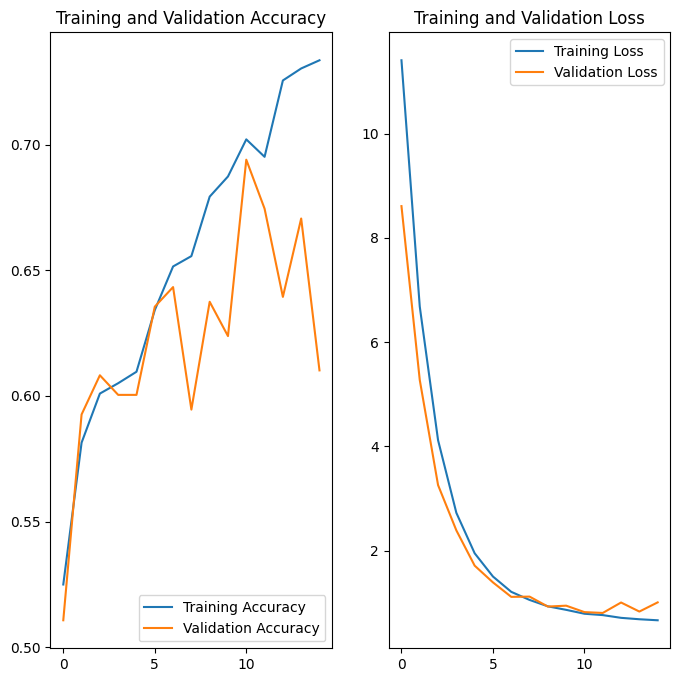

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Save the model to Google Drive
model_path = '/content/best_Xception_model.h5'
model.save(model_path)

print(f'Model saved to {model_path}')

Model saved to /content/best_Xception_model.h5


In [22]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

40/40 [==============================] - 5s 123ms/step - loss: 1.3549 - accuracy: 0.4988
Validation Accuracy: 49.88%


In [23]:
from sklearn.metrics import classification_report, accuracy_score

# Load the best model
best_model = tf.keras.models.load_model('best_Xception_model.h5')

# Predict on the test set
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(y_test, y_pred_classes, target_names=labels)
print(report)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# If you want to extract and print the precision, recall, and F1-score averages
report_dict = classification_report(y_test, y_pred_classes, target_names=labels, output_dict=True)
precision = report_dict['weighted avg']['precision']
recall = report_dict['weighted avg']['recall']
f1_score = report_dict['weighted avg']['f1-score']

print(f"Weighted Precision: {precision * 100:.2f}%")
print(f"Weighted Recall: {recall * 100:.2f}%")
print(f"Weighted F1 Score: {f1_score * 100:.2f}%")


40/40 [==============================] - 3s 63ms/step
                  precision    recall  f1-score   support

     NonDemented       0.92      0.29      0.44       640
VeryMildDemented       0.41      0.98      0.58       448
    MildDemented       0.92      0.07      0.12       179
ModerateDemented       0.50      0.08      0.14        12

        accuracy                           0.50      1279
       macro avg       0.69      0.36      0.32      1279
    weighted avg       0.74      0.50      0.44      1279

Test Accuracy: 49.88%
Weighted Precision: 73.73%
Weighted Recall: 49.88%
Weighted F1 Score: 44.40%


In [24]:
import tensorflow as tf
print(tf.__version__)

2.15.0
